In [5]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import matplotlib.pyplot as plt
import seaborn as sns
import os 
if not os.path.exists('figures'):
    os.makedirs('figures')
    
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('rainbow', n_colors=10)
!nvidia-smi

Mon Apr 15 16:10:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:4B:00.0 Off |                    0 |
| N/A   25C    P0              52W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Wigner

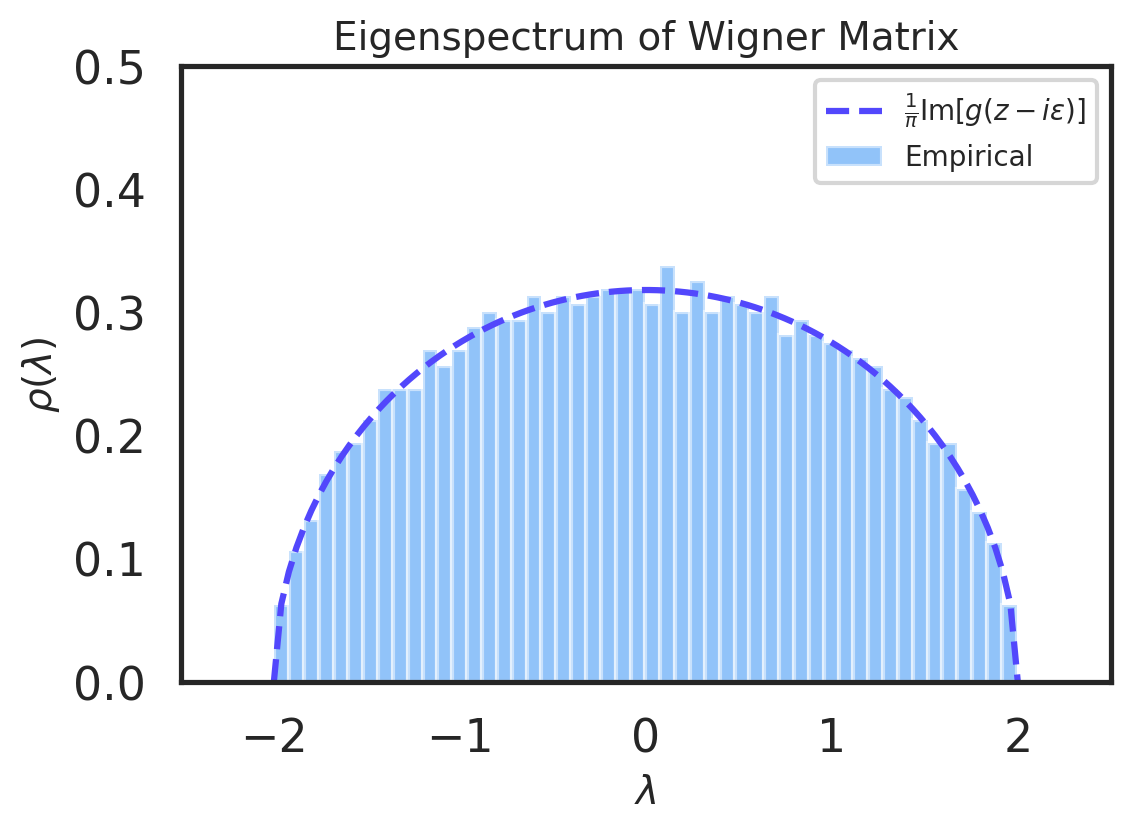

In [53]:
N = 2000
# Generate a random Gaussian matrix
A = np.random.randn(N, N) / np.sqrt(N)

# Compute the eigenvalues of A
evals, _ = np.linalg.eigh(A)

# Plot the eigenspectrum
plt.figure(figsize=(6, 4))
plt.title(f'Eigenspectrum of Wigner Matrix',fontsize=14)


# Plot the semicircle law
x = np.linspace(-2, 2, 100)
y = np.sqrt(4 - x**2) / (2* np.pi)
plt.plot(x, y, '--', label='$\\frac{1}{\\pi} \\mathrm{Im}[g(z - i \\epsilon)]$')

plt.hist(evals, bins=50, density=True, alpha=0.5, label=f'Empirical')

plt.xlabel('$\\lambda$',fontsize=14)
plt.ylabel('$\\rho(\\lambda)$', fontsize=14)
plt.xlim(-2.5, 2.5)
plt.ylim(0, 0.5)
plt.legend(fontsize=10)
plt.savefig('figures/wigner.pdf', bbox_inches='tight')

## White Wishart

In [8]:
N = 3000

all_evals = []
for i, q in enumerate(np.logspace(-1, 1, 5)):
    P = int(N/q)

    # Generate Gaussian data for N > P
    data = np.random.normal(0, 1, (N, P))

    # Compute the empirical covariance matrix and its eigenvalues
    cov_matrix = np.cov(data)
    eigenvalues = np.linalg.eigvalsh(cov_matrix)

    all_evals += [eigenvalues]
   

/tmp/ipykernel_2663828/3371225384.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((lambda_plus - l) * (l - lambda_minus)) / (2 * np.pi * q * l)


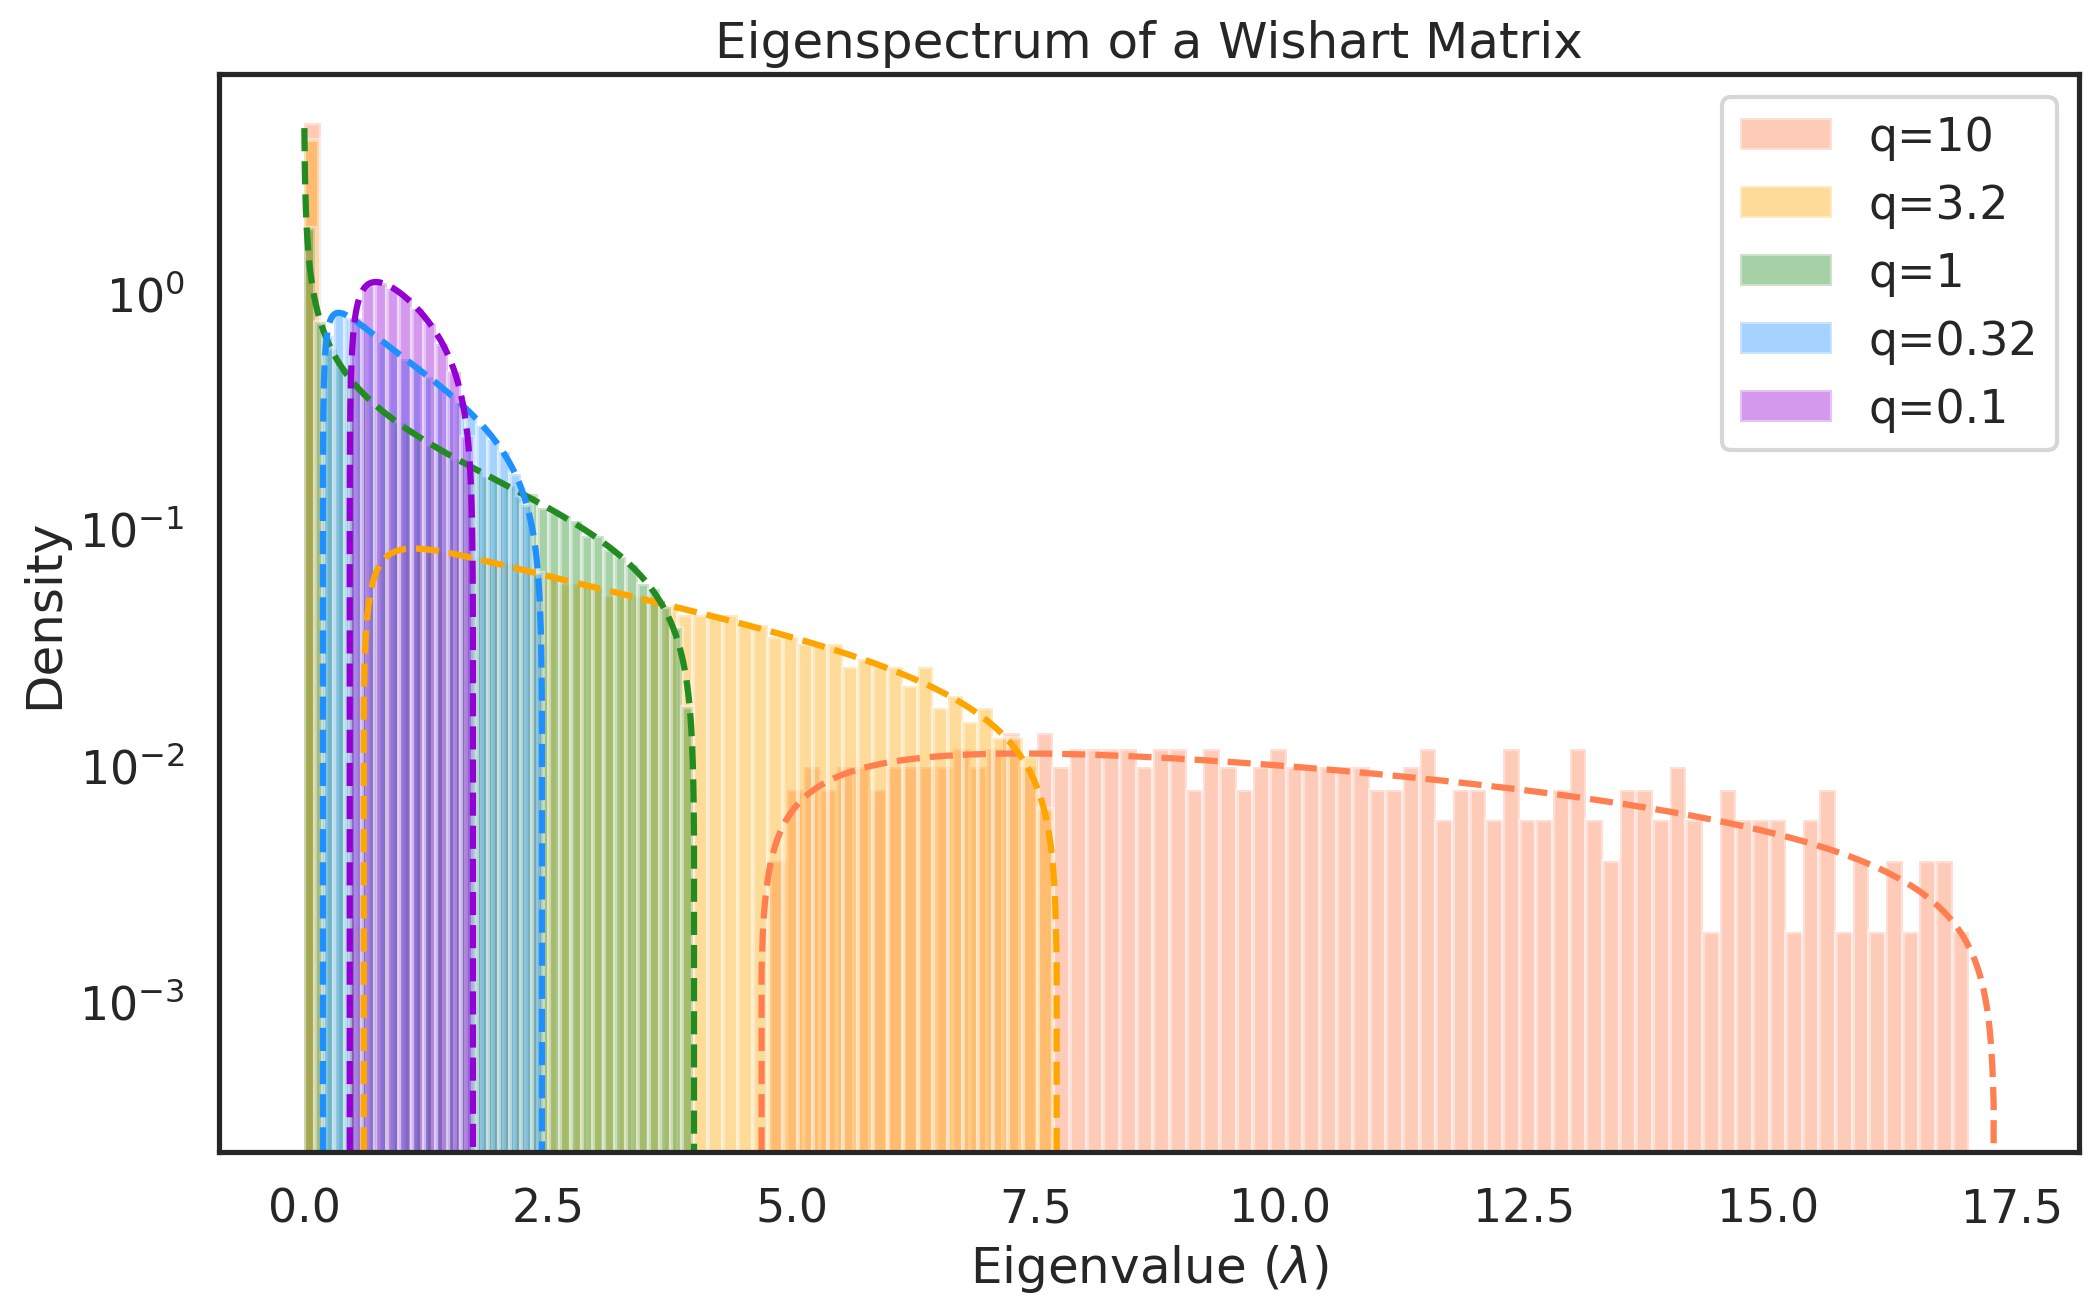

In [19]:

def theoretical_spectrum(l):
    return np.sqrt((lambda_plus - l) * (l - lambda_minus)) / (2 * np.pi * q * l)

plt.figure(figsize=(12, 7))
bins = [10, 20, 35, 50, 100]

colors = ['darkviolet', 'dodgerblue', 'forestgreen', 'orange', 'coral']

qs = np.logspace(-1, 1, 5)

for i in reversed(range(5)):
    q = qs[i]
    eigenvalues = all_evals[i]
    # Theoretical spectrum bounds and function for q > 1
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_minus = (1 - np.sqrt(q))**2


    # Plotting the empirical histogram
    # Use a range to better focus on the continuous part of the spectrum
    plt.hist(eigenvalues, bins=bins[i], density=True, alpha=0.4, color=colors[i], label=f'q={q:.2g}')

    # Adding the theoretical curve
    linspace = np.linspace(lambda_minus, lambda_plus, 1000)
    plt.plot(linspace, theoretical_spectrum(linspace), c=colors[i], ls='--')

    # Highlighting the delta function at 0
    delta_weight = 1 - 1/q

plt.xlabel('Eigenvalue ($\lambda$)')
plt.ylabel('Density')
plt.yscale('log')
plt.title('Eigenspectrum of a Wishart Matrix')
plt.legend()
plt.savefig('figures/white_wishart.pdf', bbox_inches='tight')

## Structured Wishart

In [20]:
N = 1000
b = 1.2
qs = np.logspace(-1, 1, 5)
all_evals = []
S = np.diag([k**(-b) for k in range(1, N+1)])
for i, q in enumerate(np.logspace(-1, 1, 5)):
    P = int(N/q)

    # Generate Gaussian data for N > P
    X = np.random.normal(0, 1, (P, N)) @ S**(0.5)

    # Compute the empirical covariance matrix and its eigenvalues
    cov_matrix = X.T @ X/P
    eigenvalues = sorted(np.linalg.eigvalsh(cov_matrix))[::-1]

    all_evals += [eigenvalues]
   

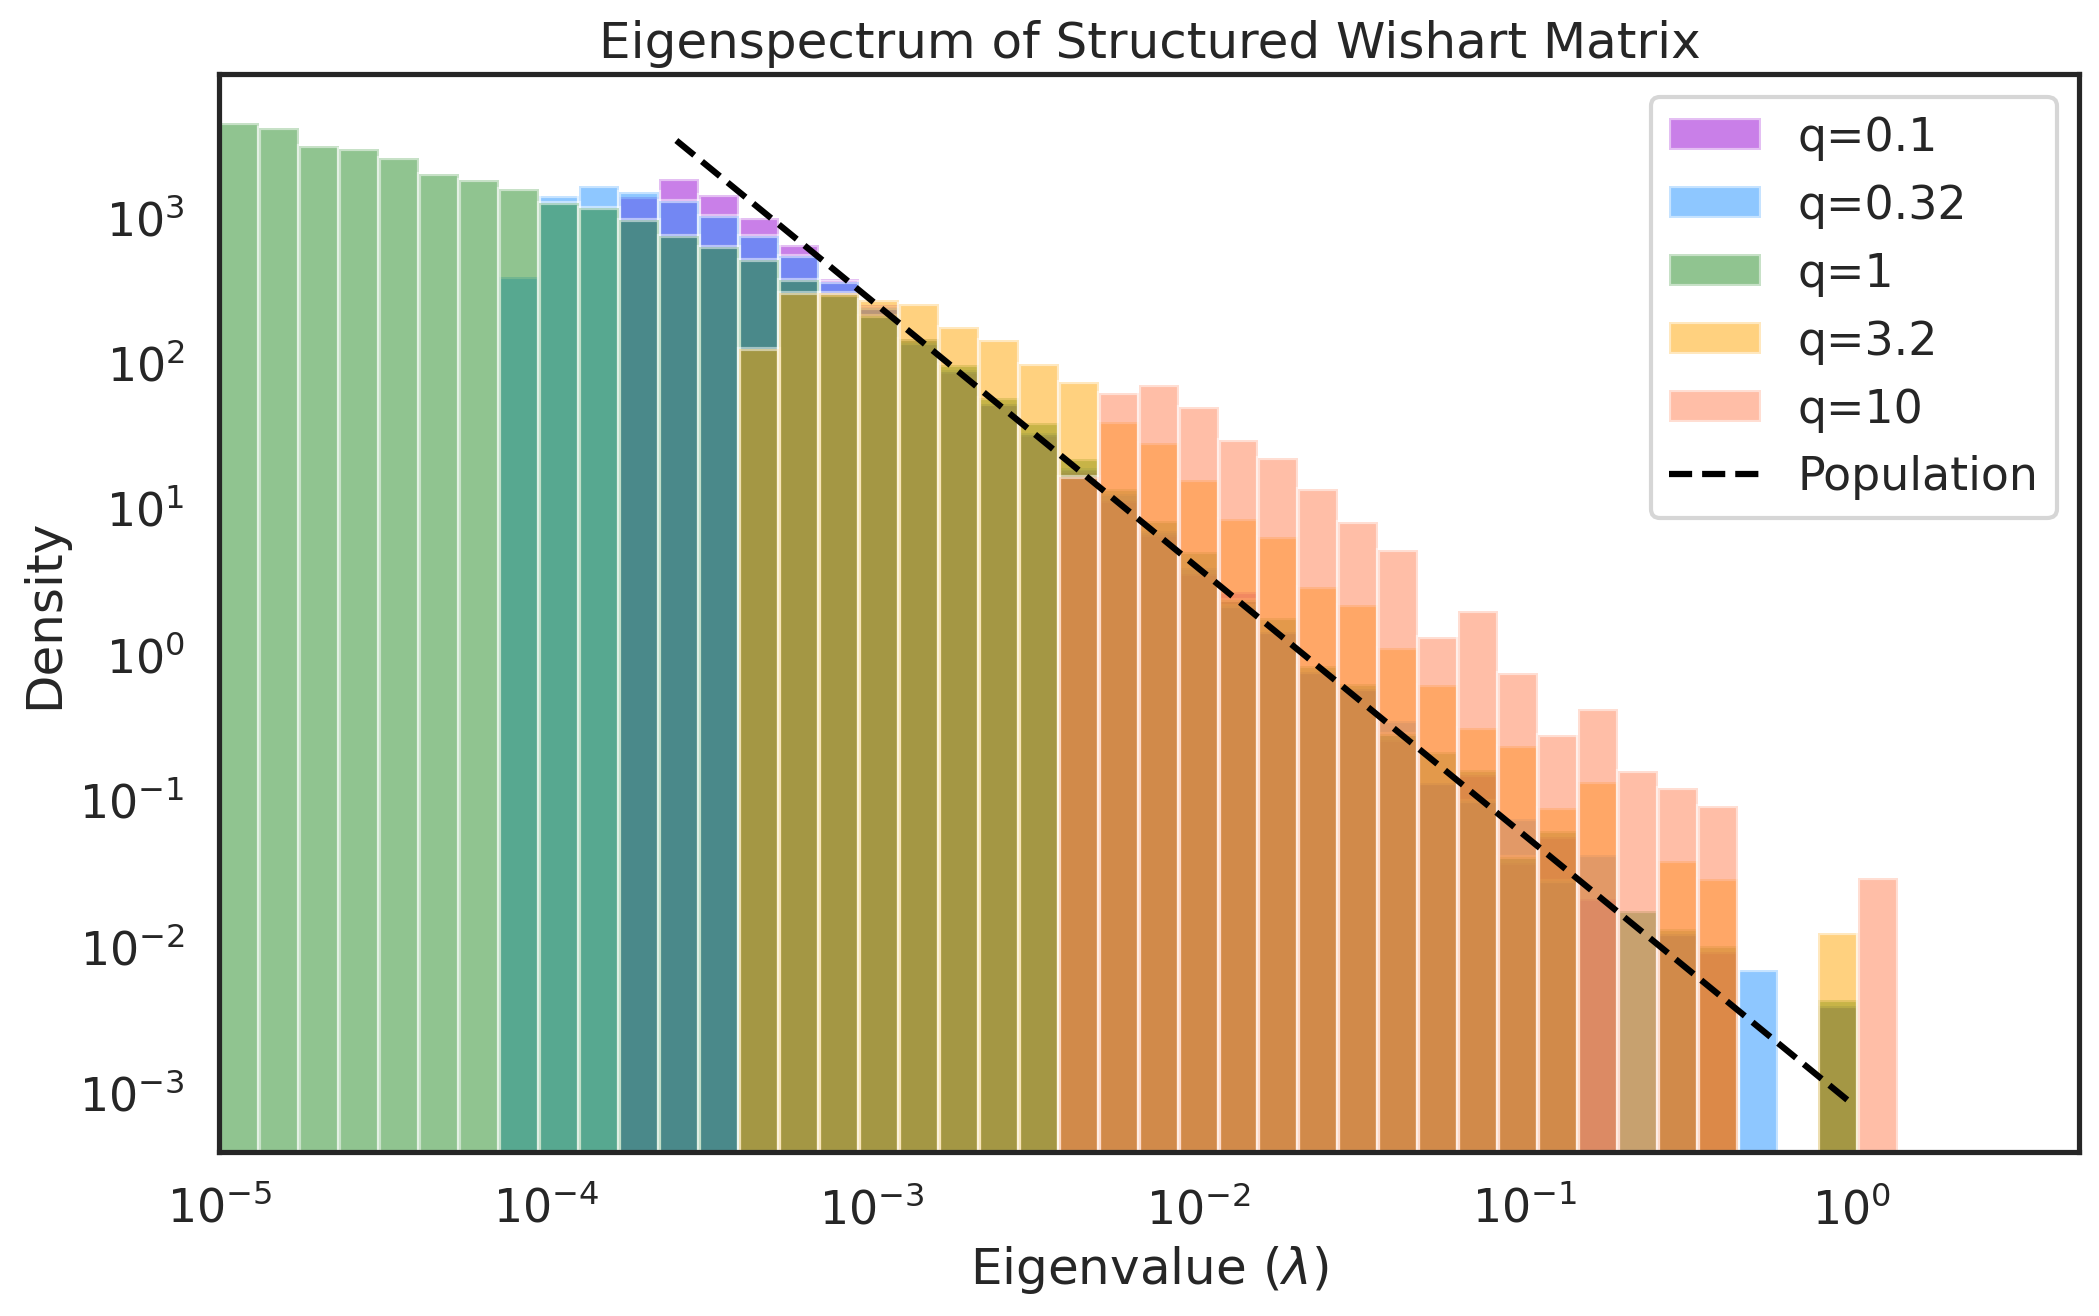

In [28]:
plt.figure(figsize=(12, 7))
sns.set_palette('rainbow', n_colors=10)
bins = [30, 30, 35, 50, 100]
qs = np.logspace(-1, 1, 5)
for i in (range(5)):
    q = qs[i]
    eigenvalues = all_evals[i]
    # Theoretical spectrum bounds and function for q > 1
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_minus = (1 - np.sqrt(q))**2

    # Plotting the empirical histogram
    # Use a range to better focus on the continuous part of the spectrum
    plt.hist(eigenvalues, bins=np.logspace(-5, 1, 50), density=True, alpha=0.5, color=colors[i], label=f'q={q:.2g}')

plt.plot(np.logspace(np.log10(N**(-b)), 0, 1000), 1/(b * (N-1)) * np.logspace(np.log10(N**(-b)), 0, 1000)**(-1-1/b), 'k--', label='Population')
plt.xlabel('Eigenvalue ($\lambda$)')
plt.ylabel('Density')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-5, 5e0)
plt.title('Eigenspectrum of Structured Wishart Matrix')
plt.legend()
plt.savefig('figures/colored_wishart.pdf', bbox_inches='tight')


(1e-07, 10.0)

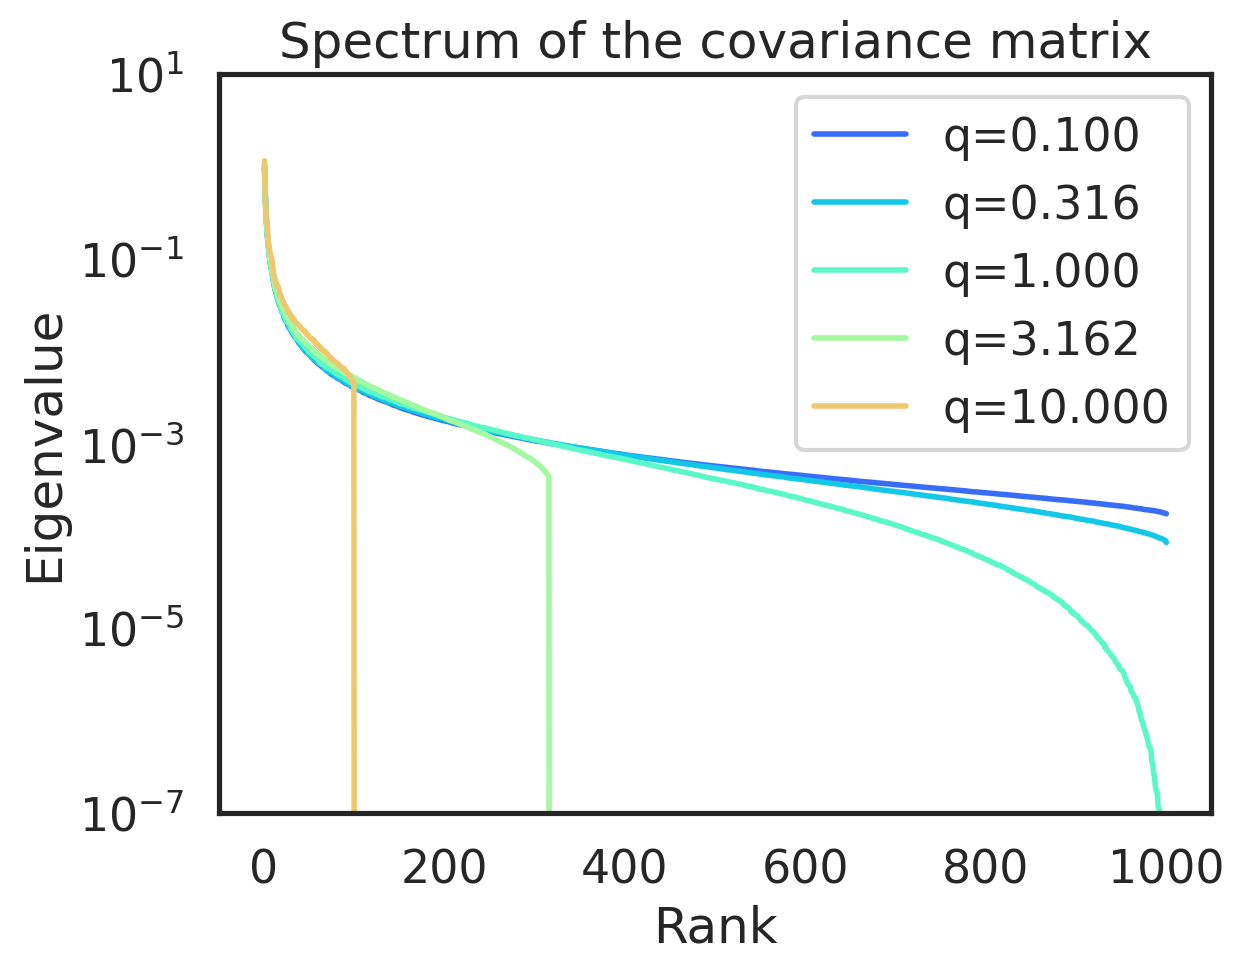

In [23]:
for q, evals in zip(qs, all_evals):
    plt.semilogy(np.arange(1, N+1), evals, lw=2, label=f'q={q:.3f}')
# plt.plot(np.arange(1, N+1), np.arange(1, N+1)**(-b), 'k--', lw=2, label='Population')
plt.xlabel('Rank')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of the covariance matrix')
plt.legend()
plt.ylim([1e-7, 1e1])

In [ ]:
def theoretical_spectrum(l):
    return np.sqrt((lambda_plus - l) * (l - lambda_minus)) / (2 * np.pi * q * l)

plt.figure(figsize=(12, 7))
bins = [10, 20, 35, 50, 100]
for i, q in enumerate(np.logspace(-1, 1, 5)):
    eigenvalues = all_evals[i]
    # Theoretical spectrum bounds and function for q > 1
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_minus = (1 - np.sqrt(q))**2

    # Prepare the plot


    # Plotting the empirical histogram
    # Use a range to better focus on the continuous part of the spectrum
    plt.hist(eigenvalues, bins=bins[i], density=True, alpha=0.5, color=f'C{i}', label=f'q={q:.3f}')

    # Adding the theoretical curve
    linspace = np.linspace(lambda_minus, lambda_plus, 1000)
    plt.plot(linspace, theoretical_spectrum(linspace), f'C{i}--')

    # Highlighting the delta function at 0
    delta_weight = 1 - 1/q

plt.xlabel('Eigenvalue ($\lambda$)')
plt.ylabel('Density')
plt.yscale('log')
plt.title('Eigenspectrum of a Wishart Matrix')
plt.legend()
plt.show()


## Deep White Wishart

In [2]:
# Re-initializing parameters for a fresh start with q > 1
Ns = [200, 1000, 6000]
L = len(Ns)

X = np.identity(Ns[0])
for i in range(1, L):
    X_l = np.random.normal(0, 1, (Ns[i-1], Ns[i]))/np.sqrt(Ns[i-1])
    X = X @ X_l
cov_matrix = X.T @ X
eigenvalues = np.linalg.eigvalsh(cov_matrix)

In [6]:
from scipy.optimize import fsolve, root
from sympy import solve, nroots, I
from sympy.abc import t
    
zs = np.linspace(0, 100, 500)
density = []
for z in zs:
    # func = lambda t: z - (t+1)/t * (1 + 0.5 * t)
    z_cx = z + I * 1e-6
    soln = nroots(z_cx*t - (t+1) * (1 + Ns[-1]/Ns[0] * t) * (1 + Ns[-1]/Ns[1] * t) )
    # pick the solution with positive imaginary part
    soln = [s for s in soln if s.as_real_imag()[1] > 0][-1]
        
    density += [(soln/(np.pi * z)).as_real_imag()[1]]


/n/home00/aatanasov/.conda/envs/scaling4/lib/python3.9/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


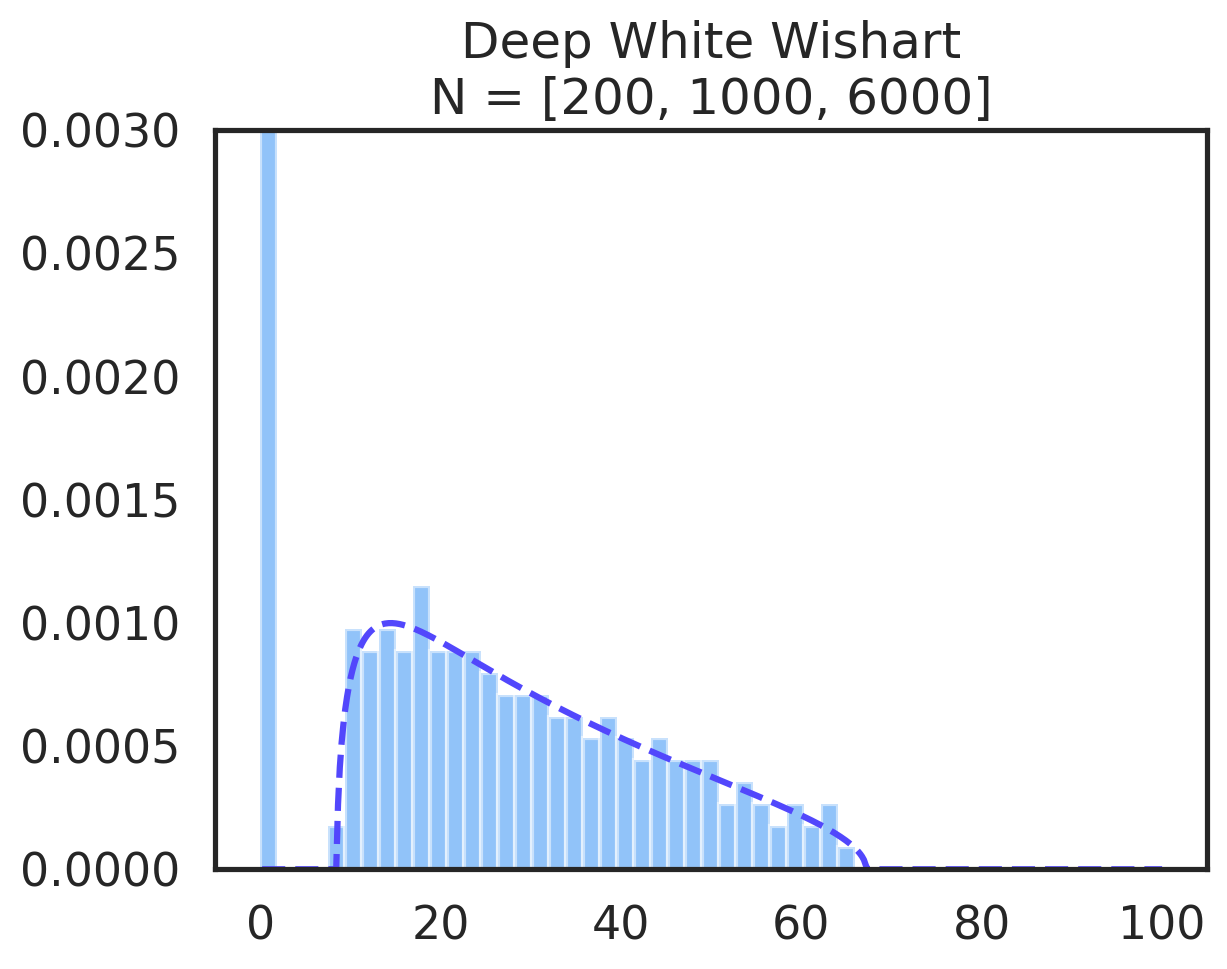

In [15]:

plt.title(f"Deep White Wishart\nN = {Ns}")
plt.plot(zs, density, '--')
plt.hist(eigenvalues, bins=35, density=True, alpha=0.5)   
plt.ylim([0, 3e-3])
plt.savefig("figures/deep_white_wishart_lin.pdf", bbox_inches='tight')

/n/home00/aatanasov/.conda/envs/scaling4/lib/python3.9/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


Text(3.1440657552083326, 0.5, 'Density')

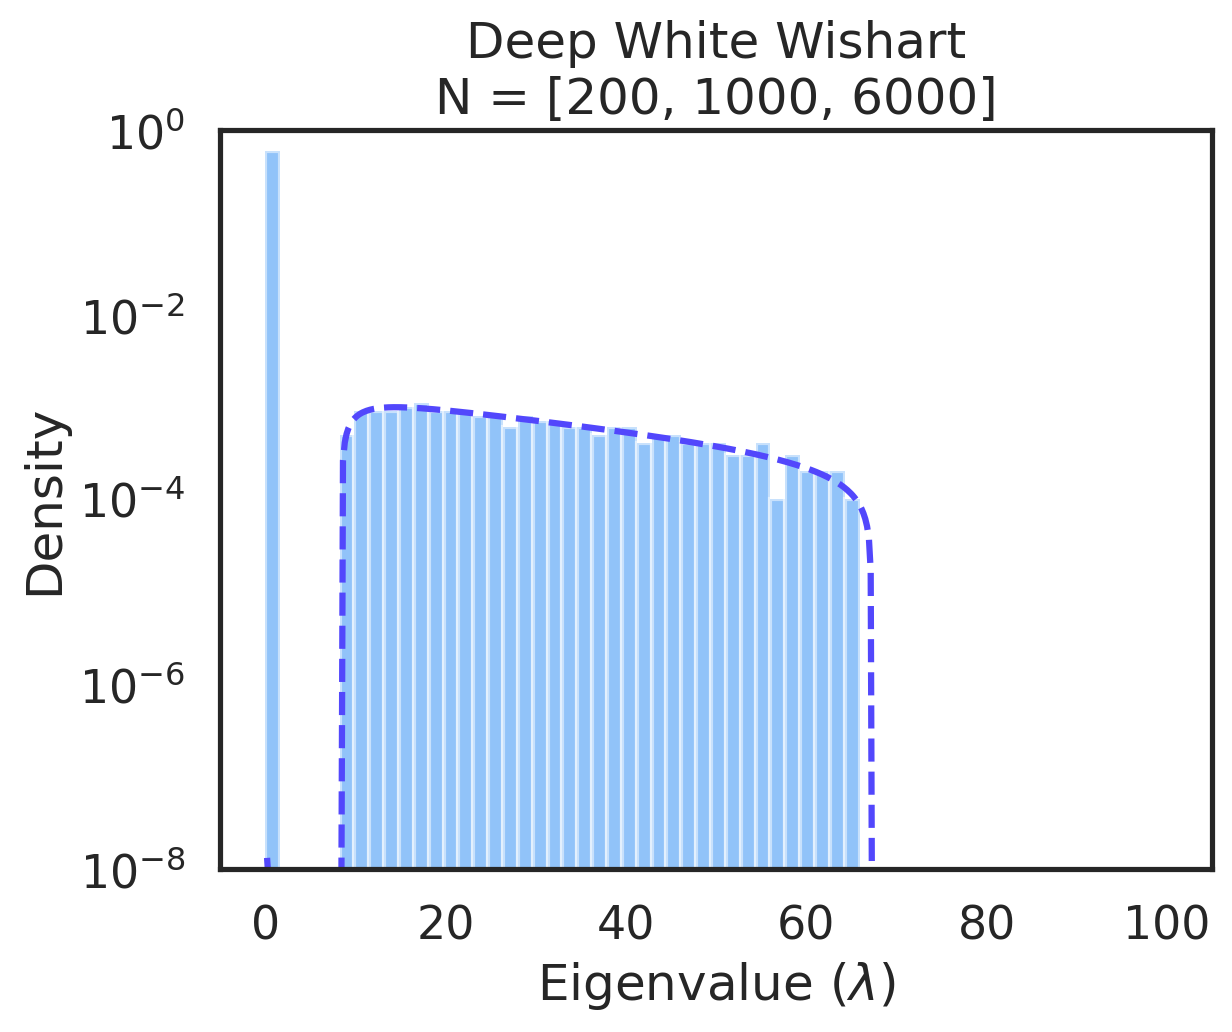

In [13]:

plt.title(f"Deep White Wishart\nN = {Ns}")
plt.plot(zs, density,  '--')
plt.hist(eigenvalues, bins=40, density=True, alpha=0.5)   
plt.yscale('log')
plt.ylim([1e-8, 1e0])
plt.savefig("figures/deep_white_wishart_log.pdf", bbox_inches='tight')
plt.xlabel("Eigenvalue ($\\lambda$)")
plt.ylabel("Density")